# Using convolutions to generalize

***Why Our Old Neural Network Didn’t Generalize Well***
In the last chapter, we built a simple neural network that could fit the training data well, but it didn’t `generalize` to new images (like unseen birds or airplanes). That’s because:

* It had too many parameters, making it easy to memorize the training data.

* It had no sense of position—a bird in the top left corner looked different to the model than the same bird in the bottom right.

We tried fixing this by using data augmentation (cropping, shifting images), but the real issue was the model design.

**The Better Idea: Convolutions**

Instead of using fully connected layers, we use a new kind of operation called a convolution, which gives our model two superpowers:

1) Locality – Looks only at small neighborhoods of pixels at a time (just like how we recognize patterns in real life).

2) Translation Invariance – Can detect the same feature no matter where it appears in the image.

***What Is a Convolution?***
* A convolution slides a small matrix (called a kernel or filter) across the image.

* At each step, it takes a weighted sum of a small patch of pixels under the kernel.

* This process helps the model learn local patterns like edges, corners, or textures.


***Example:***

* A 3×3 kernel moves across the image and multiplies pixel values by weights, adding them up to form one value in the output.

* The same weights are reused across the whole image, which means fewer parameters and better generalization.

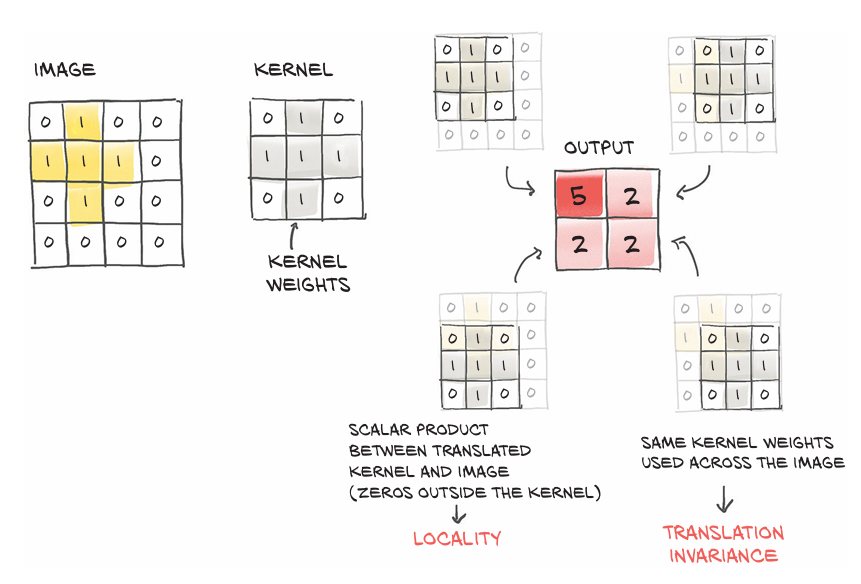


In [29]:
'''
weight = torch.tensor([[w00, w01, w02],
 [w10, w11, w12],
 [w20, w21, w22]])
'''

'\nweight = torch.tensor([[w00, w01, w02],\n [w10, w11, w12],\n [w20, w21, w22]])\n'

 1-channel, MxN image

In [30]:
'''
image = torch.tensor([[i00, i01, i02, i03, ..., i0N],
 [i10, i11, i12, i13, ..., i1N],
 [i20, i21, i22, i23, ..., i2N],
 [i30, i31, i32, i33, ..., i3N],
 ...
 [iM0, iM1m iM2, iM3, ..., iMN]])
'''

'\nimage = torch.tensor([[i00, i01, i02, i03, ..., i0N],\n [i10, i11, i12, i13, ..., i1N],\n [i20, i21, i22, i23, ..., i2N],\n [i30, i31, i32, i33, ..., i3N],\n ...\n [iM0, iM1m iM2, iM3, ..., iMN]])\n'

In [31]:
'''
o11 = i11 * w00 + i12 * w01 + i22 * w02 +
 i21 * w10 + i22 * w11 + i23 * w12 +
 i31 * w20 + i32 * w21 + i33 * w22
'''

'\no11 = i11 * w00 + i12 * w01 + i22 * w02 +\n i21 * w10 + i22 * w11 + i23 * w12 +\n i31 * w20 + i32 * w21 + i33 * w22\n'

***Why Convolutions Are Awesome***
By using convolution layers:

1) We reduce the number of parameters.

2) We focus on local patterns rather than the whole image at once.

3) We recognize patterns anywhere in the image (translation invariance).

This is exactly what we need to build smarter models that can tell birds from airplanes—even if they appear in different spots in the image.

##  Convolutions in action

***Using PyTorch’s Convolution Layers***
PyTorch provides convolution modules for different types of data:

* nn.Conv1d → for time series

* nn.Conv2d → for images (what we use for CIFAR-10)

* nn.Conv3d → for 3D data (like videos or medical scans)

For CIFAR-10 (which has 3-channel RGB images), we use

In [32]:
import torch
import torch.nn as nn
nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3)


Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))

This means:

* 3 input channels → because of R, G, and B

* 16 output channels → each one can learn to detect a different feature

* 3×3 kernel → the size of the filter that slides over the image

***Understanding the Weight Tensor***
Each convolutional layer has a weight tensor with shape:

In [33]:
'''
(out_channels, in_channels, kernel_height, kernel_width)

# for example
(16, 3, 3, 3)
'''

'\n(out_channels, in_channels, kernel_height, kernel_width)\n\n# for example\n(16, 3, 3, 3)\n'

In [34]:
conv = nn.Conv2d(3, 16, kernel_size=3) # <1>


* 16 filters

* Each filter looks at all 3 input channels

* Each filter is 3×3 in size

There's also a `bias` (one for each output channel), used just like in linear layers.

***What Happens When We Apply a Convolution***

To use this convolution layer on one image, we must add a batch dimension:

In [35]:
from torchvision import datasets

data_path = 'data/p1ch7/'
from torchvision import transforms

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4915, 0.4823, 0.4468),
                         (0.2470, 0.2435, 0.2616))
])

cifar10 = datasets.CIFAR10(
    data_path, train=True, download=False,
    transform=transform
)

cifar10_val = datasets.CIFAR10(data_path, train=False, download=False,transform=transform)


label_map = {0: 0, 2: 1}
class_names = ['airplane', 'bird']

cifar2 = [(img, label_map[label]) for img, label in cifar10 if label in [0, 2]]
cifar2_val = [(img, label_map[label]) for img, label in cifar10_val if label in [0, 2]]

img, _ = cifar2[0]                 # Get one image
output = conv(img.unsqueeze(0))   # Add batch dimension: 

output.shape → [1, 16, 30, 30]

Why is it 30×30 instead of 32×32?

* Because a 3×3 kernel eats up 1 pixel from each edge (no padding used), so we lose 2 pixels in both height and width.

***What Do These Output Channels Mean?***
Each of the 16 output channels contains a different filtered version of the image. Some may highlight edges, textures, or patterns. But since weights are randomly initialized, the output isn’t meaningful until `training happens`.

***Visualizing the Output***

We can even visualize one of the output channels:

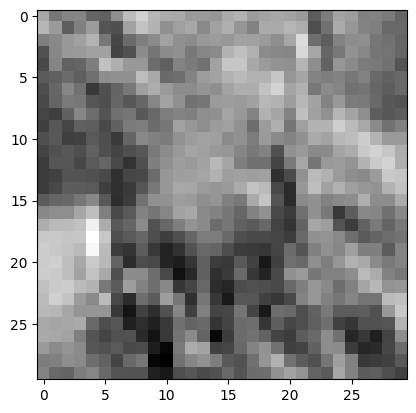

In [36]:
import matplotlib.pyplot as plt

plt.imshow(output[0, 0].detach(), cmap='gray')
plt.show()


* This shows what the image looks like after being processed by the first convolutional filter.

`Not every filter will learn something helpful. Some might end up being "useless" — this is related to the Lottery Ticket Hypothesis, which suggests that only some parts of a network contribute significantly to learning.`

### Padding the boundary

When you apply a **3×3 convolution**, you need pixels on all sides of the center pixel to perform the operation. So at the edges of the image (like the top-left corner), the kernel doesn't fully fit—and PyTorch, by default, **doesn’t pad the image**.

* That’s why your output image is 2 pixels smaller in both width and height than the input (1 pixel lost on each side).

***How to Keep the Same Size? Use Padding!***

We can solve this by adding zero padding around the image—"ghost" pixels with a value of 0.

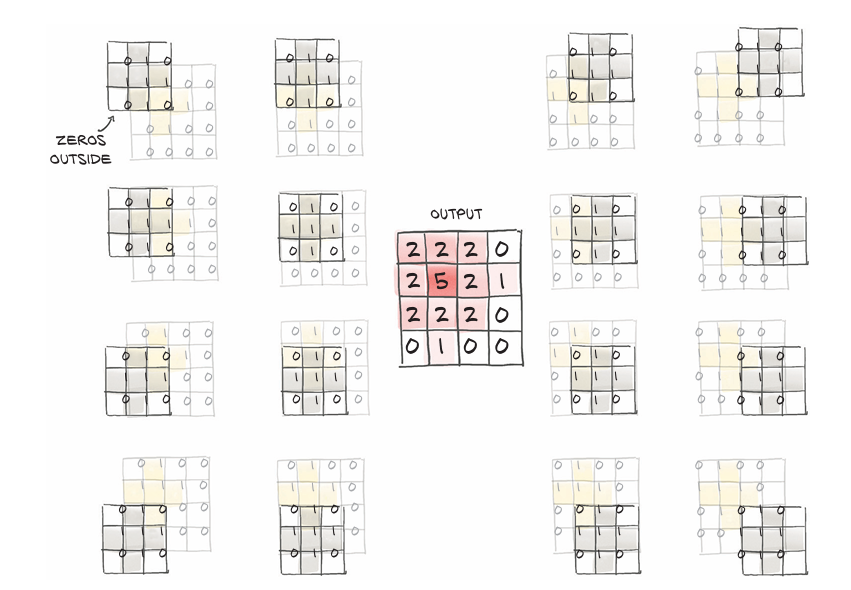

In [37]:
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)


Now the output image will be the same size as the input!

**Why this is useful:**

1) It keeps image dimensions consistent.

2) Makes it easier to build complex architectures like U-Nets or use skip connections (where you need to add or compare tensors of the same shape).

#### Detecting features with convolution

Normally, the convolution kernel’s weights are learned during training. But we can also manually set the weights to see how they behave:

***Smoothing / Blurring Filter***

In [38]:
with torch.no_grad():
    conv.bias.zero_()
    conv.weight.fill_(1.0 / 9.0)


This makes each output pixel the **average of its 3×3 neighborhood**. The result? A blurred version of the original image. Smooth transitions, less sharp detail.

**Edge Detection Filter**


In [39]:
with torch.no_grad():
    conv.weight[:] = torch.tensor([
        [-1.0, 0.0, 1.0],
        [-1.0, 0.0, 1.0],
        [-1.0, 0.0, 1.0]
    ])
    conv.bias.zero_()


This kernel highlights vertical edges in the image:

* It subtracts pixel values on the left of a center pixel from the right.

* If there’s a big difference (i.e., an edge), the result is large.

* If the area is uniform (no edge), the output is zero.

This is a **classic edge detection filter**, and it's great for spotting object boundaries.



**Deep Learning Learns Filters Automatically**

In the past, people hand-designed filters for tasks like edge detection or pattern recognition.

***Now, with convolutional neural networks (CNNs):***

1) The model learns the best filters during training.

2) Each convolutional layer builds more abstract features—starting with edges, then shapes, then objects.

You don’t have to handcraft filters anymore. The network learns what’s best to solve the task (like recognizing birds vs. airplanes).

**What Does a CNN Actually Learn?**

A convolutional neural network (CNN) learns:

* A set of filters (kernels) layer by layer.

* These filters transform an image into new versions that highlight specific features.

***For example:***

1) One channel might detect edges.

2) Another might respond to textures.

3) Others might capture shapes or colors.

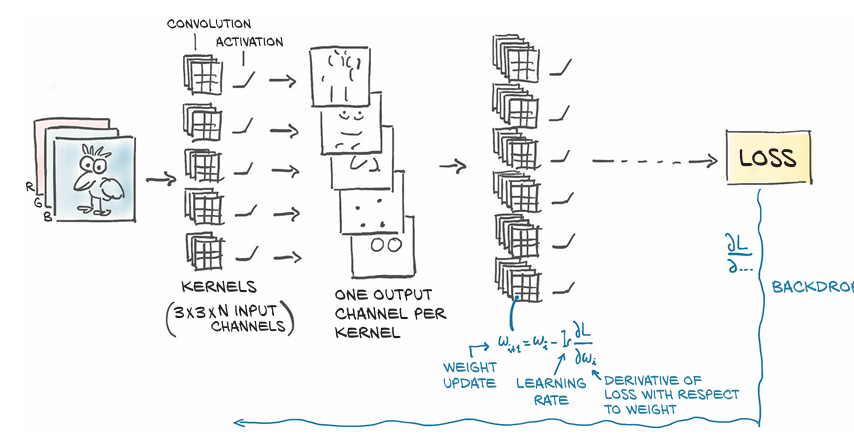

### Looking further with depth and pooling

When we use small convolution kernels (like 3×3 or 5×5), we’re great at detecting local patterns (edges, corners, etc.), 
* but what about larger patterns in images—like the full shape of a bird or an airplane? Small kernels alone can't capture those.


To solve this, we stack multiple convolutional layers and reduce image size between them—a process called downsampling. 
* This helps the network "see" larger patterns step-by-step without using huge kernels that would behave like fully connected layers.

---
Downsampling Methods:
1) Average Pooling: Takes the average of a group of pixels. Less common nowadays.

2) Max Pooling: Keeps the highest value from each group. Most popular today—it keeps the strongest signals.

3) Strided Convolutions: Skips some pixels when applying convolutions. Promising but less used than max pooling.

Why Max Pooling?
1) Keeps the strongest detected features.

2) Commonly applied over non-overlapping 2×2 patches, reducing image size by half while retaining key features.

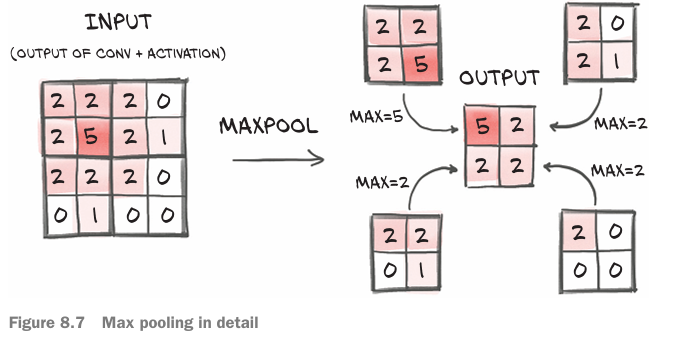

In [40]:
pool = nn.MaxPool2d(2)
output = pool(img.unsqueeze(0))
print(output.shape)  # [1, 3, 16, 16]


torch.Size([1, 3, 16, 16])


If img is a 32×32 image, the output shape becomes 16×16—effectively downsampled by half.

***Combining Convolutions and Downsampling***
When we stack convolutions with downsampling (like max pooling), we allow neural networks to detect larger and more complex patterns in an image.

* `First step:`
Apply a 3×3 convolution to an 8×8 image. This gives a new image with features like edges or textures.

* `Downsampling:`
Then, we reduce the size of the image (e.g., using 2×2 max pooling), shrinking it to 4×4. This keeps important features while reducing data.

* `Second step:`
Apply another 3×3 convolution to this smaller image. Even though this kernel is still 3×3, it now corresponds to a larger area (8×8) in the original image.

* `Why this is powerful:`

    * The first convolution captures small/local details (low-level features).

    * The second convolution captures bigger structures by combining those low-level features.

This layered approach gives Convolutional Neural Networks (CNNs) the ability to "see" and understand complex parts of an image, not just small patches.

* `Receptive Field:`
The final output pixel of this two-layer structure is influenced by an 8×8 region of the original image. This area is called the receptive field.

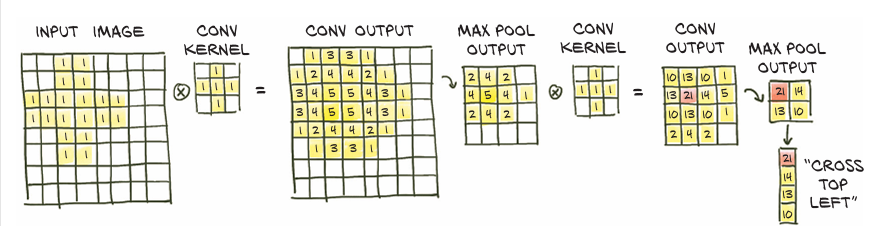

#### Building a CNN to Detect Birds and Airplanes
Now that we've learned how convolutions and pooling work, let's put them together to build a CNN that can tell the difference between birds and airplanes.

**Network Structure**

We start by stacking layers using PyTorch’s nn.Sequential:

In [41]:
model = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, padding=1),  # 3 → 16 channels
    nn.Tanh(),
    nn.MaxPool2d(2),                             # Downsample to 16x16

    nn.Conv2d(16, 8, kernel_size=3, padding=1),  # 16 → 8 channels
    nn.Tanh(),
    nn.MaxPool2d(2),                             # Downsample to 8x8

    nn.Linear(8 * 8 * 8, 32),                    # Flatten and connect
    nn.Tanh(),
    nn.Linear(32, 2)                             # Output: bird or airplane
)


***How it works***
1) The image starts as a 3-channel RGB image.

2) The first convolution creates 16 feature maps, and pooling reduces the size to 16×16.

3) The second convolution makes 8 feature maps, and another pooling reduces it to 8×8.

4) The total output after pooling is 8×8×8 = 512 features.

5) These are fed into fully connected layers to finally predict two probabilities: one for bird and one for airplane.

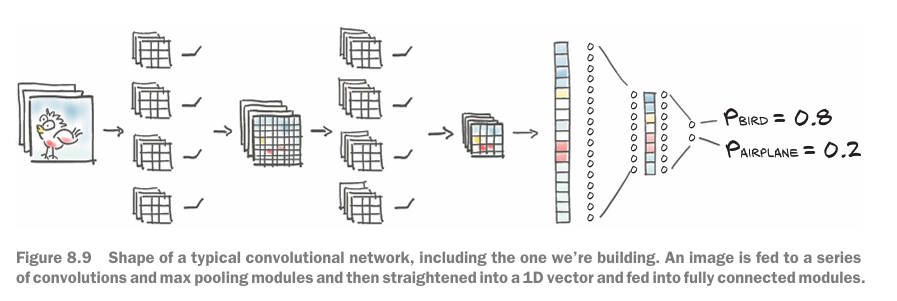

***The Missing Flatten Step***
If you try to run this, it will crash:

1) PyTorch expects a 1D vector input for nn.Linear.

2) After pooling, we still have a 2D feature map (8 channels of 8×8).

3) We need to flatten this into a vector of 512 elements before passing it to the nn.Linear.

But since we're using nn.Sequential, we don’t have a way to insert the flatten step easily.



In [42]:
numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

***Model Size***
* The model has around 18,090 parameters, which is small and efficient for tiny images like those in CIFAR-10.

*If needed, we can increase model capacity by increasing the number of channels.

### Building Custom Neural Networks with `nn.Module`
Sometimes, we need to go beyond what nn.Sequential allows. For example, we might want to reshape data or add custom logic like residual connections. To do this, we use nn.Module subclassing.

***Why Use nn.Module?***
1) nn.Sequential is great for simple, straight-through models.

2) But if we need more control, like reshaping tensors (which we couldn't do in nn.Sequential), we need to define our own class by subclassing nn.Module.

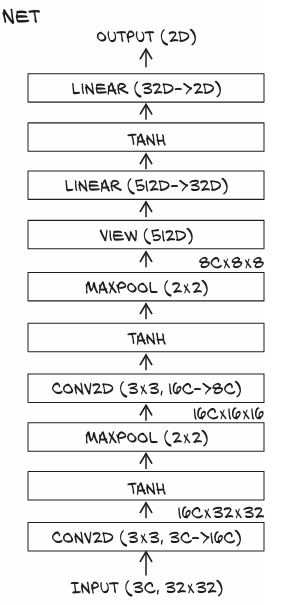

In [43]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()  # Always call this first!
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.act1 = nn.Tanh()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.act2 = nn.Tanh()
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.act3 = nn.Tanh()
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        x = self.pool1(self.act1(self.conv1(x)))
        x = self.pool2(self.act2(self.conv2(x)))
        x = x.view(-1, 8 * 8 * 8)  # Reshape for the linear layer
        x = self.act3(self.fc1(x))
        x = self.fc2(x)
        return x


***What’s Happening in the Code?***
* We define each layer (like conv1, pool1, etc.) in __init__.

* In forward, we control the data flow, including reshaping with .view(), which we couldn’t do inside nn.Sequential.

* -1 in view(-1, ...) keeps the batch size flexible.

***Why Reshape Matters***

After convolution and pooling, our output is still a 3D tensor (channels, height, width). But fully connected layers expect a 1D vector per sample, so we flatten the tensor (e.g., 8×8×8 = 512).

***The Goal of Classification Networks***
* We start with high-dimensional inputs (like images).

* Then, layer by layer, we compress the information into a small vector of class probabilities (e.g., bird vs. airplane).

* This is usually done by:

    * Reducing pixel size (via pooling).

    * Reducing channels (or sometimes increasing them, like in ResNets).

    * Using fewer neurons in final fully connected layers.

***Comparison with ResNet***
* Our simple network shrinks data quickly, which works well for small images and shallow models.

* In deeper models like ResNet, pooling is used more gradually, and channels often increase instead of decrease.



### How PyTorch Tracks Parameters and Submodules
When we build models in PyTorch by subclassing nn.Module, the framework helps us manage parameters and layers (aka submodules) automatically—as long as we follow some rules.

***Registering Submodules Automatically***
* When we assign a layer (like nn.Conv2d, nn.Linear, etc.) to an attribute inside the __init__ method of a model class, PyTorch automatically registers it as a submodule.



allows PyTorch to track that layer—and its parameters—correctly.

***Important: Submodules must be top-level attributes.***

* You can’t just store them in a list or dictionary, unless you use special PyTorch containers:

    * Use nn.ModuleList if you need a list of layers.

    * Use nn.ModuleDict if you need a dictionary of layers.

***Accessing Parameters***
* When you call model.parameters(), PyTorch automatically:

    * Goes through all submodules.

    * Collects all parameters (like weights and biases), no matter how deeply nested they are.

    * This makes it easy to pass them to the optimizer.

In [44]:
model = Net()
numel_list = [p.numel() for p in model.parameters()]
print(sum(numel_list), numel_list)


18090 [432, 16, 1152, 8, 16384, 32, 64, 2]


This prints the total number of trainable parameters in the model.



***Optimization Tip***
*Layers like nn.Tanh() and nn.MaxPool2d() don’t have any trainable parameters.

* So, instead of registering them as attributes in __init__, you could just call them directly in forward()—this keeps your model cleaner without affecting functionality.

### Using the Functional API in PyTorch
PyTorch provides two ways to build neural networks:

1) Modular API – Using nn.Module, like nn.Conv2d, nn.Linear, etc.

2) Functional API – Using functions from torch.nn.functional, like F.max_pool2d and F.relu

***What is the Functional API?***
* Functional operations have no internal state. That means they don’t store any parameters.

* They simply return an output based on the input values and parameters you pass in.

In [45]:
#F.linear(input, weight, bias)  # Functional form


is the functional version of nn.Linear.

***When to Use Functional vs. Modular***
* `Use nn.Module` for layers with parameters (like nn.Linear, nn.Conv2d) so PyTorch can track and train them.

* `Use functional calls` (like F.tanh, F.max_pool2d) for operations without parameters, like activations and pooling.

Here’s an updated version of our model using the functional API:

In [46]:
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        x = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        x = F.max_pool2d(torch.tanh(self.conv2(x)), 2)
        x = x.view(-1, 8 * 8 * 8)
        x = torch.tanh(self.fc1(x))
        x = self.fc2(x)
        return x


CN: F functions doesnt keep track/change the gradiant

This version is cleaner and shorter than before, and it works exactly the same

***Tips and Warnings***
* Functional API is great for simplicity, but only use it when the operation has no trainable parameters.

* If you plan to do quantization (advanced model optimization), it’s safer to use the modular version, even for activations and pooling.

* Reusing stateless modules like nn.ReLU() multiple times can cause issues with tools like TorchScript, so it's better to create a new instance each time if using the modular approach.

***Running the Model***

In [47]:
model = Net()
model(img.unsqueeze(0))


tensor([[-0.1350,  0.1089]], grad_fn=<AddmmBackward0>)

CN: Both the model and the data basically everythnig should be moved to the gpu-> both have to be on the same devide, model and inputs and everything, everything must be registered to the gpu. As well as architecture parameter.

You’ll get two output values, representing probabilities for the two classes (e.g., bird vs. airplane). The model is working!

### Training a Convolutional Neural Network (ConvNet)
Now that we’ve built our CNN model, it’s time to train it! This involves feeding in batches of images, calculating the loss, adjusting model weights, and checking how well it performs.

***The Training Loop***
We train the model using two nested loops:

* Outer loop: over epochs

* Inner loop: over batches from the DataLoader


At each step, we:

1) Feed the images into the model → Forward pass

2) Calculate the loss using a loss function like CrossEntropyLoss

3) Clear out old gradients → optimizer.zero_grad()

4) Backpropagate the loss → loss.backward()

5) Update the model’s parameters → optimizer.step()

Here’s a simplified version of the training loop:

In [48]:
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_train += loss.item()
        if epoch == 1 or epoch % 10 == 0:
            print(f"Epoch {epoch}, Training loss {loss_train / len(train_loader)}")


***Preparing for Training***
Before calling the training loop:

In [49]:
import torch.optim as optim
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)
model = Net()
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()
training_loop(100, optimizer, model, loss_fn, train_loader)


Epoch 1, Training loss 0.6069083441594604
Epoch 10, Training loss 0.339600556785134
Epoch 20, Training loss 0.30362343133255176
Epoch 30, Training loss 0.276841926726566
Epoch 40, Training loss 0.2543257484865037
Epoch 50, Training loss 0.23539454807901078
Epoch 60, Training loss 0.22056060583348486
Epoch 70, Training loss 0.2025069230396277
Epoch 80, Training loss 0.18611258424960883
Epoch 90, Training loss 0.16827822362731218
Epoch 100, Training loss 0.15454382157534552


* DataLoader batches the images and shuffles them

* We train for 100 epochs

* Training time depends on your hardware

***Measuring Accuracy***
Training loss is useful, but we also want to know how well the model actually classifies images. That’s where accuracy comes in.

In [50]:
def validate(model, train_loader, val_loader):
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0
        with torch.no_grad():  # Disable gradient tracking
            for imgs, labels in loader:
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1)
                total += labels.shape[0]
                correct += int((predicted == labels).sum())
        print(f"Accuracy {name}: {correct / total:.2f}")


Then we call:

In [51]:
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64, shuffle=False)

validate(model, train_loader, val_loader)


Accuracy train: 0.93
Accuracy val: 0.89


### HomWork 

***Results***
* Training accuracy: 93%

* Validation accuracy: 89%

This is much better than our earlier fully connected model (which had ~79% accuracy), while using fewer parameters!

***Why the CNN Works Better***
* Convolutions capture local image patterns.

* Pooling adds translation invariance, meaning the model can recognize objects in different positions.

* It generalizes better to unseen data—exactly what we want in real-world applications.



***Saving a Model***
To save a model’s parameters (weights and biases), use:

In [52]:
torch.save(model.state_dict(), 'birds_vs_airplanes.pt')


This saves only the learned parameters, not the structure of the model. So when you load it later, you need to:

1) Have the same model class (Net) defined, and

2) Create an instance, then load the saved weights:

In [53]:
loaded_model = Net()
loaded_model.load_state_dict(torch.load('birds_vs_airplanes.pt'))


<All keys matched successfully>

***Training on a GPU***
Training on a GPU can significantly speed up your model—especially for large datasets and deep networks.

***Check if a GPU is available and set the device:***

In [54]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Training on device {device}")


Training on device cuda


***Move the model to the device:***

In [55]:
model = Net().to(device=device)


During training, move data batches to the same device:

In [ ]:
for imgs, labels in train_loader:
    imgs = imgs.to(device)
    labels = labels.to(device)
    ...


Same for validation, make sure data is on the same device as the model.

***Updated Training Loop with GPU Support***

In [56]:
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            imgs = imgs.to(device)
            labels = labels.to(device)
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_train += loss.item()

        if epoch == 1 or epoch % 10 == 0:
            print(f"Epoch {epoch}, Training loss: {loss_train / len(train_loader)}")


***Loading a Model on a Different Device***

When loading a saved model, PyTorch tries to load it to the device it was saved from. You can override this using map_location:

In [57]:
loaded_model = Net().to(device)
loaded_model.load_state_dict(torch.load('birds_vs_airplanes.pt', map_location=device))


<All keys matched successfully>

### Designing Better Models and Making Them Wider

Now that we’ve successfully trained a convolutional neural network (CNN), you might wonder: What’s next? What if the task is more complex?

***Real-World Problems Are Harder***
Our birds vs. airplanes dataset was simple: small, centered images. But in the real world (e.g., ImageNet), images are larger, more complex, and often require picking up on multiple visual clues.

Also, data doesn’t always come as images—think:

* Tabular data (spreadsheets)

* Sequences (time-series, EEG)

* Text (sentences, documents)

`Neural networks can handle all of these—if we use the right architecture and loss function.`

---

***PyTorch is Very Flexible***
PyTorch provides:

* Modules for CNNs, RNNs (like LSTMs), and Transformers.

* Tools to build and train custom architectures.

* Access to pretrained models via PyTorch Hub and TorchVision.

So, if you can read a research paper, you can usually build it in PyTorch—or understand someone else’s code.

***Adding Memory Capacity: Making Models Wider***
One way to improve model performance is to increase its width (aka more channels or neurons per layer). This helps the model learn more complex features.

In [58]:
class NetWidth(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 16, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(16 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        x = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        x = F.max_pool2d(torch.tanh(self.conv2(x)), 2)
        x = x.view(-1, 16 * 8 * 8)
        x = torch.tanh(self.fc1(x))
        x = self.fc2(x)
        return x


CN: the kernerl is set to 32....what are the other parameters?...








***Parameterized Version (for flexibility)***
You can also pass the width as a parameter, so you can easily test different sizes:

In [59]:
class NetWidth(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8 * 8 * (n_chans1 // 2), 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        x = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        x = F.max_pool2d(torch.tanh(self.conv2(x)), 2)
        x = x.view(-1, 8 * 8 * (self.n_chans1 // 2))
        x = torch.tanh(self.fc1(x))
        x = self.fc2(x)
        return x


***More Width = More Power (and More Risk)***

* Wider models have more parameters → Can learn more complex features

    * Example: This model has 38,386 parameters

But be careful:

* More parameters = higher risk of overfitting

* If the model is too powerful, it might just memorize the training data

***How to Combat Overfitting***
* Best solution: More training data

* Next best: Data augmentation (e.g., flipping, cropping, adding noise)

* other tricks at the model level (e.g., dropout, regularization)
---

### Helping Our Model Learn Better with Regularization
When we train neural networks, we care about two big things:

1) `Optimization` – making the model do well on the training data

2) `Generalization` – making sure the model works well on new, unseen data

Regularization helps with both.

### Regularization Strategy 1: Keep the Weights Small (L2 Regularization / Weight Decay)
`Why?`

- Large weights often mean the model is memorizing the training data.

- L2 regularization adds a penalty for large weights during training.

- This helps the model generalize better.

`How?`

- We add a small extra term to the loss function that depends on the size of the weights.

- This discourages the model from making any weight too large.

***In PyTorch, you can:***
Option 1: Manually add L2 regularization to the loss:

In [ ]:
l2_lambda = 0.001
l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())
loss = loss + l2_lambda * l2_norm


Option 2 (recommended): Just use weight_decay in your optimizer:


In [ ]:
optimizer = optim.SGD(model.parameters(), lr=1e-2, weight_decay=0.002)


This is equivalent, easier, and faster.

***Regularization Strategy 2: Dropout***

`Why?`
* Sometimes neurons team up too much during training (overfitting).

* Dropout randomly turns off (zeroes out) parts of the network during training.

* Each batch is trained with a slightly different version of the model.

`How?`
* Dropout helps the model learn to rely on many neurons, not just a few.

* This makes the model more robust and reduces overfitting.

***In PyTorch:***
Use nn.Dropout (for linear layers) or nn.Dropout2d (for conv layers).

In [ ]:
class NetDropout(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv1_dropout = nn.Dropout2d(p=0.4)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3, padding=1)
        self.conv2_dropout = nn.Dropout2d(p=0.4)
        self.fc1 = nn.Linear(8 * 8 * (n_chans1 // 2), 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        x = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        x = self.conv1_dropout(x)
        x = F.max_pool2d(torch.tanh(self.conv2(x)), 2)
        x = self.conv2_dropout(x)
        x = x.view(-1, 8 * 8 * (self.n_chans1 // 2))
        x = torch.tanh(self.fc1(x))
        x = self.fc2(x)
        return x

Dropout is only active during training. During evaluation (testing or deployment), it turns off automatically.

In [ ]:
model.train()  # Enables dropout
model.eval()   # Disables dropout


***Why This All Matters***
These techniques help you:

* Avoid overfitting

* Make your models more general

* Achieve better accuracy on real-world (unseen) data

You don’t need huge datasets or massive models—just smart tricks like regularization!

---

**Keeping Activations in Check with Batch Normalization***

As deep learning models grew in size, researchers realized that stabilizing activations can lead to faster and better training. That’s where Batch Normalization comes in.

***Why Use Batch Normalization?***
Introduced in 2015 by researchers at Google, batch normalization:

* Speeds up training

* Makes the model less sensitive to weight initialization

* Allows for higher learning rates

* Acts as a form of regularization (like dropout—but differently)

It helps prevent the `"activation explosion or collapse"` problem, where activations get stuck in saturated areas of functions like __tanh__ or __sigmoid__, which can kill gradients.

***How It Works***
For each minibatch, batch normalization:

1) Calculates the mean and standard deviation of activations across the batch.

2) Shifts and scales the activations so they’re more centered and standardized.

3) Applies learnable scaling and shifting parameters so the network can still learn optimal distributions.

This standardization stabilizes learning and adds slight randomness during training—helping prevent overfitting.

***Using BatchNorm in PyTorch***
Use different types depending on your data shape:

* nn.BatchNorm1d → For linear layers

* nn.BatchNorm2d → For image data (2D convolutions)

* nn.BatchNorm3d → For 3D data (e.g., video or volumetric scans)

Example: CNN with Batch Normalization

In [ ]:
class NetBatchNorm(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv1_batchnorm = nn.BatchNorm2d(n_chans1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3, padding=1)
        self.conv2_batchnorm = nn.BatchNorm2d(n_chans1 // 2)
        self.fc1 = nn.Linear(8 * 8 * (n_chans1 // 2), 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        x = self.conv1_batchnorm(self.conv1(x))
        x = F.max_pool2d(torch.tanh(x), 2)
        x = self.conv2_batchnorm(self.conv2(x))
        x = F.max_pool2d(torch.tanh(x), 2)
        x = x.view(-1, 8 * 8 * (self.n_chans1 // 2))
        x = torch.tanh(self.fc1(x))
        x = self.fc2(x)
        return x


***Training vs. Inference Mode***
* During training, batch norm uses statistics from the current batch.

* During inference (evaluation), batch norm uses pre-computed averages across training batches.

In [ ]:
model.train()  # Uses batch statistics (default for training)
model.eval()   # Uses running averages (for inference)


Just like with dropout, this behavior is automatically updated for all submodules when you switch modes.

***Why Use It?***
* Reduces internal noise and variability during training

* Helps the model learn faster and more reliably

* Can sometimes reduce or replace the need for dropout

### Going Deeper to Learn More Complex Features (Depth)
So far, we’ve improved our model by making it wider (more channels). The next big upgrade? Make it deeper—by stacking more layers.

***Why Go Deeper?***
* Deeper networks can understand more complex and hierarchical patterns in data.

* For example, in images:

    * A shallow model might detect a human silhouette

    * A deeper model might detect a face, eyes, or even facial expressions

More layers = more processing steps = the ability to learn more abstract features.



***There’s a Problem...***
When models get really deep (20+ layers), training becomes difficult. Why?

***Vanishing gradients:***
Gradients (used to update weights) become too small in early layers. These layers stop learning.

***The Solution: Skip Connections (a.k.a. Residual Connections)***
In 2015, ResNets (Residual Networks) introduced a fix:

* They add shortcuts in the model by skipping over layers and adding the input back in later.

* This lets gradients flow more directly backward and helps deep networks train successfully.

Think of it like giving the network a backup path so important signals don’t get lost.

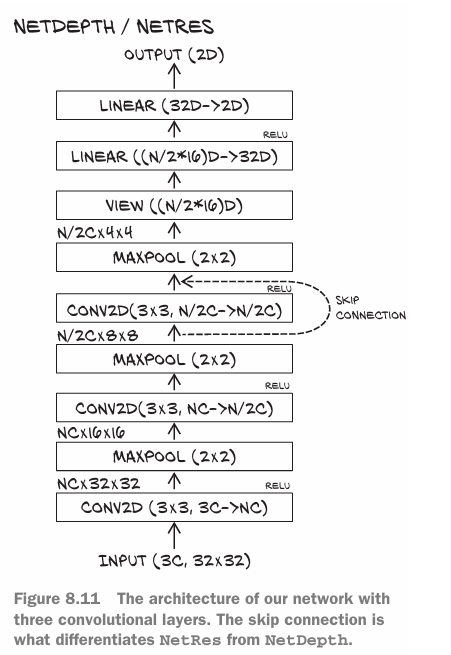

Example Without Skip Connection

In [ ]:
class NetDepth(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(n_chans1 // 2, n_chans1 // 2, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(4 * 4 * (n_chans1 // 2), 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        x = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        x = F.max_pool2d(torch.relu(self.conv2(x)), 2)
        x = F.max_pool2d(torch.relu(self.conv3(x)), 2)
        x = x.view(-1, 4 * 4 * (self.n_chans1 // 2))
        x = torch.relu(self.fc1(x))
        return self.fc2(x)


Now with a Skip Connection (Residual Style)

In [ ]:
class NetRes(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(n_chans1 // 2, n_chans1 // 2, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(4 * 4 * (n_chans1 // 2), 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        x = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        x = F.max_pool2d(torch.relu(self.conv2(x)), 2)
        skip = x  # Save for the shortcut
        x = F.max_pool2d(torch.relu(self.conv3(x)) + skip, 2)
        x = x.view(-1, 4 * 4 * (self.n_chans1 // 2))
        x = torch.relu(self.fc1(x))
        return self.fc2(x)


 We add the output of an earlier layer (skip) to a later layer, helping the network remember important signals.

***Why Skip Connections Help***
1) Prevent vanishing gradients

2) Speed up convergence (faster training)

3) Enable very deep models (like ResNet-152!)

4) Smoother loss landscape → Easier to optimize

***Beyond ResNet: Even Deeper Architectures***
1) DenseNet: Connects each layer to several others (not just the next one)

2) This allows even better information flow and fewer parameters

***Building Very Deep Models in PyTorch***
So far, we've seen how deeper networks can learn more complex patterns, especially with skip connections (like in ResNet). But how do we build a 100-layer network in PyTorch without losing our minds?

### Use Building Blocks
Rather than writing 100 layers by hand (which would be madness!), we use a reusable block called a ResBlock.

Each ResBlock includes:

1) A convolution

2) Batch normalization

3) ReLU activation

4) A skip connection (adds input back to output)

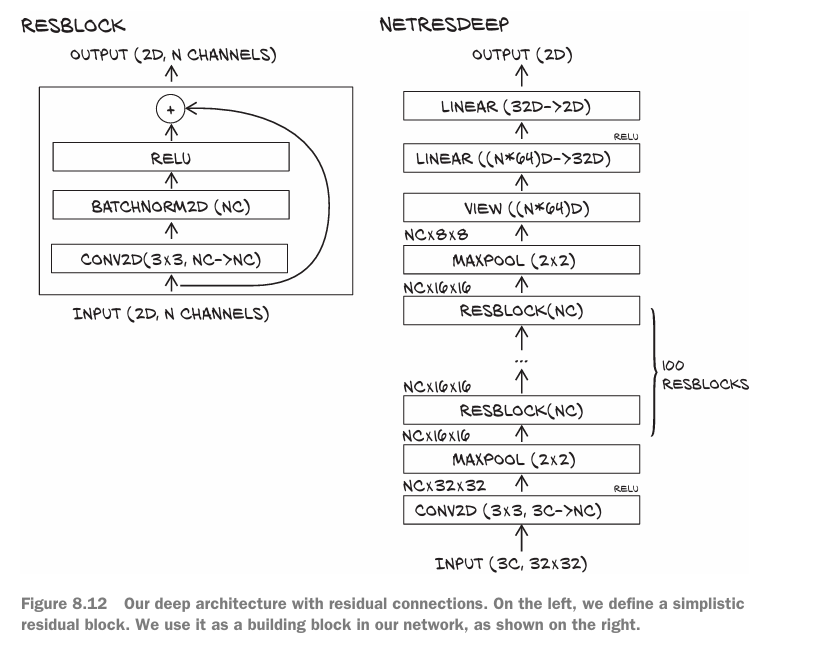

Example: One ResBlock

In [ ]:
class ResBlock(nn.Module):
    def __init__(self, n_chans):
        super().__init__()
        self.conv = nn.Conv2d(n_chans, n_chans, kernel_size=3, padding=1, bias=False)
        self.batch_norm = nn.BatchNorm2d(n_chans)

        # Custom weight initialization
        torch.nn.init.kaiming_normal_(self.conv.weight, nonlinearity='relu')
        torch.nn.init.constant_(self.batch_norm.weight, 0.5)
        torch.nn.init.zeros_(self.batch_norm.bias)

    def forward(self, x):
        out = self.conv(x)
        out = self.batch_norm(out)
        out = torch.relu(out)
        return out + x  # Skip connection


***Building the Deep Network***
We create a model (NetResDeep) that uses:

1) A single initial convolution

2) A sequence of many ResBlocks (e.g., 100!)

3) Fully connected layers for output

In [ ]:
class NetResDeep(nn.Module):
    def __init__(self, n_chans1=32, n_blocks=100):
        super().__init__()
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.resblocks = nn.Sequential(
            *(n_blocks * [ResBlock(n_chans=n_chans1)])
        )
        self.fc1 = nn.Linear(8 * 8 * n_chans1, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        x = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        x = self.resblocks(x)
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 8 * 8 * self.n_chans1)
        x = torch.relu(self.fc1(x))
        return self.fc2(x)


`nn.Sequential` helps us stack blocks easily, and n_blocks lets us choose how deep to go.

***Things to Watch Out For***
*`Deeper networks are slower` and harder to train.

You may need to:

1) Use batch normalization

2) Use custom weight initialization

3) Reduce the learning rate (e.g., from 1e-2 to 3e-3)

***What About Initialization?***
PyTorch’s default weight initialization isn’t always ideal, especially for deep networks.

To help with convergence:

* We used Kaiming initialization for convolution weights.

* We initialized batch norm to have:

    * Mean = 0

    * Variance = 0.5 (instead of 1.0) — to prevent exploding activations

You'll learn more about initialization in later chapters, but for now, just know: initialization matters.

***What This Teaches Us***
* We now know how to build deep models cleanly and flexibly.

* This approach is exactly how real ResNet models (and even DenseNets) are implemented in PyTorch.

* While 100-layer models are overkill for small datasets (like CIFAR-10), they're essential for complex data like ImageNet or medical scans.
---

***Comparing Model Designs & Staying Up-to-Date***
In this section, we experimented with several network design choices like:

1) Weight decay (L2 regularization)

2) Dropout

3) Batch normalization

3) Increased depth and width

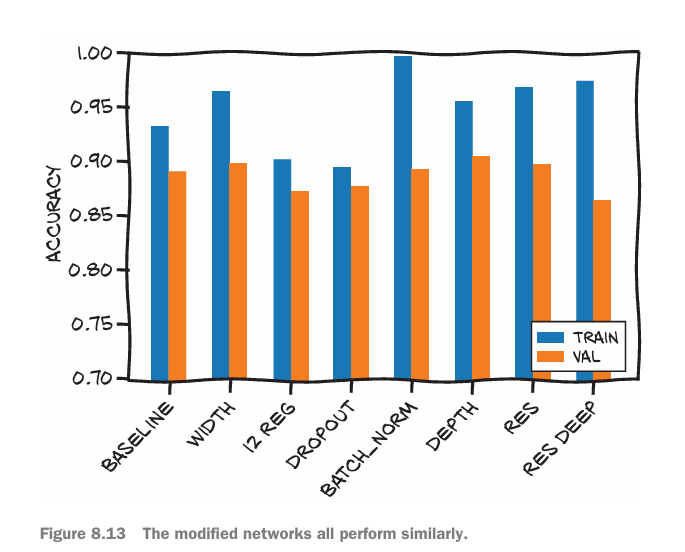

***What Did We Learn?***
* All the modified networks performed `similarly` on our simple task.

* `Dropout and weight decay` are strong regularization tools—they kept the gap between training and validation accuracy small, which is a sign of good generalization.

* `Batch normalization` helped the model train faster and reach very high training accuracy, but it may not regularize as strongly as the others.

`So:`

* Dropout and weight decay = regularization

* Batch norm = helps convergence (training goes faster and smoother)

`Don't overinterpret exact accuracy numbers—they can change with different random seeds or hyperparameters.`



***Deep Learning Changes Fast***
* New architectures and ideas emerge constantly.

* What’s “cutting edge” today might be outdated next year.

But here's the good news:

- You now have the core skills to understand and implement what you read in papers or find on GitHub.

`Keep practicing turning ideas into PyTorch code—that’s how you’ll stay sharp and adaptable in this fast-moving field.`